# COVID-19 Aftermath on Search Trends

Since the COVID-19 health crisis started to heavily affect most industries in the US, we started to see a big shift in relative search interest (RSI), from a behavioral standpoint, many of these shifts seem obvious, however, there are a lot of winners and losers that might not be so obvious. For that reason, we decided to embark on a quest to understand more precisely what this change means for our clients, and for the industry as a whole, using some Python wizardry we'll try to systematically collect the data and provide insights for each specific category of content.

So, without further ado, let's start our data collection process by first importing the necessary modules and libraries we'll be using.

In [1]:
#Let's start by importing the necessary modules
from pytrends.request import TrendReq
from datetime import datetime, date, time
import plotly.express as px
import pytrends
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import datetime

## Connections and Data Collection

In order to understand how relative search interest has changed in the last few weeks, we'll use the Pytrends library to connect to the Google Trends API and query the data for the specific categories/industries we are interested in analyzing. 

In [2]:
#Connect to Google
pytrends = TrendReq(hl='en-US')

#Build Payload
#Test random kw or kw list
kw_list = ['Real Estate']
pytrends.build_payload(kw_list, timeframe='today 5-y', geo = 'US', cat = 29)

To start, let's query a single topic (Real Estate), and let's get a glimpse of the type of data we get.

In [3]:
interest_over_time_df = pytrends.interest_over_time() 
print(interest_over_time_df.tail(3))

            Real Estate  isPartial
date                              
2020-04-05           66      False
2020-04-12           69      False
2020-04-19           70      False


As we can see from the table above the API is returning a table-like structure with the date by week as an index, the relative search interest (RSI) value for that week and a boolean value to declare whether or not we have the data for the full week or just partial data.

For fun, let's do a simple plot of how this particular topic's trend has behaved across time. As a default, we'll be looking at data for the past 5 years.

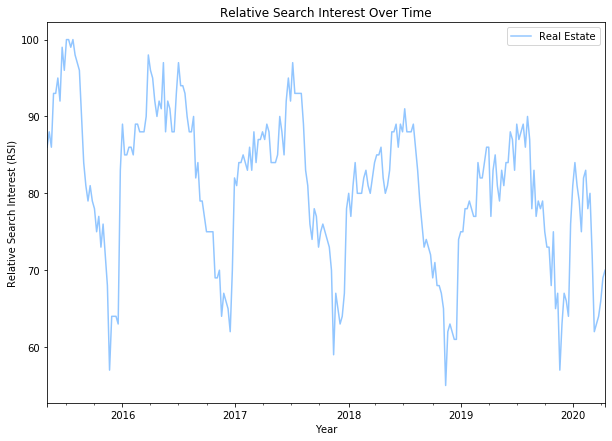

In [4]:
#Plot the results
plt.style.use('seaborn-pastel')
_ = interest_over_time_df.plot(figsize = (10,7))
_.set_title('Relative Search Interest Over Time', color='black')
_.set_xlabel('Year')
_.set_ylabel('Relative Search Interest (RSI)')
plt.show()

It seems that there's a cyclic nature to this topic, however, the drop in RSI usually happens at the end of the year and not in the first Q1 of the year as we can see on the chart, which suggests an impact from the recent COVID-19 health crisis. Now, the goal of this analysis is to look at this decrease in RSI across the major online categories defined by Google Trends.  All categories and subcategories can be found here: https://github.com/pat310/google-trends-api/wiki/Google-Trends-Categories

We'll only be reviewing top-level categories. 

Let's continue our analysis by loading our list of categories from a flat-file and print the size of this list.

In [15]:
#Load the list of topics (search terms)
searches = pd.read_csv('searches.csv').values
searches = list(searches)
#Review the number of categories (search terms)
len(searches)

28

Since Google Trend only allows us to query 5 topics at a time, we'll individually query each topic and use a for loop to iterate over our list of categories to later merge the data on a single data frame.

In [6]:
#Iterate over the list of main categories
topics = {}
i = 1
for topic in searches:
    pytrends.build_payload(topic, timeframe = 'today 5-y', geo = 'US')
    topics[i] = pytrends.interest_over_time()
    i+=1

In [7]:
#Create a data frame with the results
df = pd.concat(topics, axis=1)
df.columns = df.columns.droplevel(0)
#Drop the last observation which usually contains partial data
df = df[:-1]
#Drop the duplicate 'isPartial' columns
df = df.drop('isPartial', axis = 1)
#Print the size of the data frame and the last 5 rows
print("Size of the dataframe :", df.shape)
df.tail()

Size of the dataframe : (259, 26)


,Arts & Entertainment,Beauty & Fitness,Books & Literature,Business & Industrial,Computers & Electronics,Finance,Food & Drink,Games,Health,Home & Garden,...,Pets & Animals,Real Estate,Reference,Science,Shopping,Sports,Travel,Jewelry,Pet Food,Fabric
2020-03-15,18,0,39,20,38,100,32,55,100,25,...,0,61,70,50,88,51,69,38,100,35
2020-03-22,17,0,0,0,55,89,20,60,93,29,...,0,63,79,56,85,47,39,38,88,51
2020-03-29,34,0,37,0,18,74,23,60,85,43,...,0,66,83,57,92,44,37,39,88,90
2020-04-05,17,20,0,58,36,66,19,57,77,55,...,0,67,82,54,85,44,31,40,84,100
2020-04-12,50,0,0,0,0,72,19,59,73,45,...,0,70,86,56,72,49,31,45,86,75


As we can see from the data frame preview above we have a similar structure to the one we got on the first query, but now we have the same data for all of our categories of interest. 

As this is a somewhat inconvenient way to digest the information, we can create an interactive graph to look at RSI trends over time for each category.

In [9]:
tidy_df = df.reset_index().melt(id_vars=["index"])
px.line(tidy_df, x="index", y="value", color="variable", title='Relative Search Interest Over Time (RSI)',
       labels={ # replaces default labels by column name
                "index": "Trend Over Time",  "variable": "Category", "value": "RSI"}, template="plotly_white")

On the chart above we can click on each category to turn on/off each value, which a far better way to digest the information we've collected. Generally, we can see a decrease in specific categories such as 'Real Estate' and 'Jewelry' but others such as 'Pet Food' and 'Fabrics' tell a very different story. 

To understand specifically the impact of COVID-19 we need to review and compare specific time frames (weeks) with their average from the past 5 years, that way we won't be misled by seasonal changes in RSI.

In [ ]:
#Save file to CSV
df.to_csv(r'/Users/omarmartinez/Desktop/lego-database/Arc Tests/Trends_Data.csv')